In [ ]:
# Define the standard imports|
import torch
import torch.nn as nn
import numpy as np
import cv2
from __future__ import print_function 
from __future__ import division
import time
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
import pandas as pd
import random
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import f1_score
from PIL import Image
import os
from os import listdir
from os.path import isfile, join
import copy
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
device = ("cuda" if torch.cuda.is_available() else "cpu")

# Preparing the training data

In [ ]:
labels = pd.read_csv("./train.csv")
labels_test = pd.read_csv("./test.csv")
sample_submission = labels_test

In [ ]:
selected_breed_list = list(labels.groupby('ClassName').count().sort_values(by='ImageId', ascending=False).head(NUM_CLASSES).index)
labels = labels[labels['ClassName'].isin(selected_breed_list)]
labels = labels.sample(n = 1000) # Randomly sampling only 500 images for training/validation

train = labels.sample(frac=0.9) # Only 90% of the images will be used for training
valid = labels[~labels['ImageId'].isin(train['ImageId'])]   # 10% of the images will be used for validation

class_dict = {} # Name -> index
class_reverse_dict = {} # Index -> name
labels_unique, counts = np.unique(train["ClassName"],return_counts=True) # Getting the unique classes and their counts

for index,name in enumerate(labels_unique): 
    class_dict[name] = index
    class_reverse_dict[index] = name

1000


In [ ]:
def foodDataset(labels, root_dir, transform=None):
    img_name = '{}'.format(labels.iloc[len(labels), 0])
    fullname = join(root_dir, img_name)
    image = Image.open(fullname)
    labels = float(class_dict[labels.iloc[len(labels), 1]])
    if transform:
        image = transform(image)
    return [image, labels]


In [ ]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
ds_trans = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomVerticalFlip(),
                               transforms.ColorJitter((0.8, 1.2),(0.8, 1.2), (0.8, 1.2),(-0.1, 0.1)),
                               normalize,
                              ])

ds_trans_val = transforms.Compose([transforms.Resize(224),
                                   transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize,
                                  ])

900
100


# Defining the model

# Custom Model

# Much better implementation of a neural network

In [ ]:
class Customnet(nn.Module):
    def __init__(input_list, in_ch, num_class):
        self.in_channels = in_ch
        self.num_class = num_class
        self.linear = nn.Sequential(
            nn.Linear(32 * int(224/(2**(len(input_list)/2))) * int(224/(2**(len(input_list)/2))), 500),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(500, num_classes),
        )
        
        layers = []
        input_channels = self.in_channels
        
        for l in input_list:
            if type(l) == int:
                out_channels = l
                layers += [
                    nn.Conv2d(out_channels=out_channels,in_channels=in_channels,kernel_size=(3, 3),stride=(1, 1),padding=(1, 1),),
                    nn.ReLU(),
                ]
                in_channels = l
            
            else :
                layers += func(l)
                
    self.conv_layer = nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x
    
    def func(type_ps):
        if type_ps == "M" :
                    return [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]
        elif type_ps == "AP":
                    return [nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))]
        elif type_ps == "FMP" :
                    return [nn.FractionalMaxPool2d(kernel_size=(2, 2), stride=(2, 2))]
        elif type_ps == "AAP":
                    return [nn.FractionalMaxPool2d(kernel_size=(2, 2), stride=(2, 2))]
        elif type_ps == "BN" :
                    return [nn.BatchNorm2d(in_channels)]
        elif type_ps == "BN": 
                    return nn.BatchNorm2d(in_channels)

        elif type_ps == "relu": 
                    return nn.ReLU()

        elif type_ps == "tanh": 
                    return nn.Tanh()

        elif type_ps == "sigmoid":
                    return nn.Sigmoid()

        elif type_ps == "dropout": 
                    return nn.Dropout2d()

# Training the network

In [ ]:
def my_run(data,target,flag):
  data = data.to(device)
  target = target.to(device)
  if (flag==1):
    optimizer.zero_grad()
    output = model(data)
    softmax = nn.LogSoftmax(dim = 1) 
    output = softmax(output)
    loss = criterion(output, target.long())
    loss = loss.to(device)
    loss.backward()
    optimizer.step()
  if (flag==0):
    output = model(data)
    softmax = nn.LogSoftmax(dim = 1) 
    output = softmax(output)
    _, predicted = torch.max(output.data, 1)
    loss = criterion(output, target.long())
  return loss.item()*data.size(0)


def call_val(val_dataloader):
  a2 = len(val_dataloader.sampler)
  # validate the model
  valid_loss = 0 
  model.eval()
  for data, target in val_dataloader:
      valid_loss += my_run(data,target,flag=0)
  return (valid_loss/a2)
def call_train(train_dataloader):
  # train the model
  train_loss = 0 
  model.train()
  a1 = len(train_dataloader.sampler)
  for data, target in train_dataloader:
      train_loss += my_run(data,target,flag=1)
  return (train_loss/a1)

In [ ]:
def train_network(model, optimizer, criterion, n_epochs):

    train_loss_list = []
    val_loss_list = []
    epoch_list = range(1,n_epochs+1)

    for epoch in range(n_epochs):
        start_time = time.time()
        loss_t = call_train(train_dataloader)
        loss_v = call_train(val_dataloader)
        train_loss_list.append(loss_t)
        val_loss_list.append(loss_v)
        
        print('Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

        print("--- %s seconds ---" % (time.time() - start_time))

    return train_loss_list, val_loss_list, epoch_list

In [ ]:
my_train = foodDataset(train, './train_images', transform=ds_trans) # This class will return images and labels when called by the dataloader
my_valid = foodDataset(valid, './train_images', transform=ds_trans_val)

In [ ]:
train_dataloader = DataLoader(my_train, batch_size=64, num_workers=8)
val_dataloader = DataLoader(my_valid, batch_size=64, shuffle=True, num_workers=8)

# Variations

In [ ]:
def get_op(my_list):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  model = Customnet(my_list).to(device)
  model= nn.DataParallel(model)
  print(model)
  optimizer1 = optim.Adam(model.parameters(), lr = 0.001)
  criterion1 = nn.NLLLoss().cuda()
  train_loss_list_3layers, val_loss_list_3layers, epoch_list_3layers = train_network(model, optimizer1, criterion1, 50)

#### 3 Layers

In [ ]:
train_loss_list_3layers, val_loss_list_3layers, epoch_list_3layers = get_op([32,"M",32,"M",32,"M"])

DataParallel(
  (module): Customnet(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (linear): Sequential(
      (0): Linear(in_features=25088, out_features=500, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=500, out_features=500, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.5, inplace=False)
      (6): Linear(in_features=500, out_features=61, bias=True)
    )
  )
)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x14f97c0302b0>>
Traceback (most recent call last):
  File "/home/avinash123/miniconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/avinash123/miniconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/home/avinash123/miniconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x14f97c0302b0>>
Traceback (most recent call last):
  File "/home/avinash123/miniconda3/envs/fa

  File "/home/avinash123/miniconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/avinash123/miniconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/home/avinash123/miniconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child processException ignored in: 
<bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x14f97c0302b0>>
Traceback (most recent call last):
  File "/home/avinash123/miniconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/avinash123/miniconda3/envs/fastai/lib/python3.6/site-packages/torch/u

Epoch: 1 	 Training Loss: 3.965760 	 Validation Loss: 3.774958
--- 6.409089803695679 seconds ---
Epoch: 2 	 Training Loss: 3.798178 	 Validation Loss: 3.728521
--- 6.319573163986206 seconds ---
Epoch: 3 	 Training Loss: 3.731324 	 Validation Loss: 3.723679
--- 6.337101221084595 seconds ---
Epoch: 4 	 Training Loss: 3.729714 	 Validation Loss: 3.696461
--- 5.8729002475738525 seconds ---
Epoch: 5 	 Training Loss: 3.705525 	 Validation Loss: 3.677430
--- 6.046351432800293 seconds ---
Epoch: 6 	 Training Loss: 3.647161 	 Validation Loss: 3.607631
--- 6.045887231826782 seconds ---
Epoch: 7 	 Training Loss: 3.597565 	 Validation Loss: 3.591535
--- 6.140627384185791 seconds ---
Epoch: 8 	 Training Loss: 3.579119 	 Validation Loss: 3.531872
--- 5.982309818267822 seconds ---
Epoch: 9 	 Training Loss: 3.529903 	 Validation Loss: 3.509597
--- 6.040138483047485 seconds ---
Epoch: 10 	 Training Loss: 3.515268 	 Validation Loss: 3.581724
--- 6.007734775543213 seconds ---
Epoch: 11 	 Training Loss: 3

#### 5 Layers

In [ ]:
train_loss_list_5layers, val_loss_list_5layers, epoch_list_5layers = get_op([32,"M",32,"M",32,"M",32,"M",32,"M"])

DataParallel(
  (module): Customnet(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): ReLU()
      (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU()
      (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, di

#### 4 Layers

In [ ]:
train_loss_list_4layers, val_loss_list_4layers, epoch_list_4layers = get_op([32,"M",32,"M",32,"M",32,"M"])

DataParallel(
  (module): Customnet(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): ReLU()
      (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (linear): Sequential(
      (0): Linear(in_features=6272, out_features=500, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): 

#### 2 Layers

In [ ]:
train_loss_list_2layers, val_loss_list_2layers, epoch_list_2layers = get_op([32,"M",32,"M"])

DataParallel(
  (module): Customnet(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (linear): Sequential(
      (0): Linear(in_features=100352, out_features=500, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=500, out_features=500, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.5, inplace=False)
      (6): Linear(in_features=500, out_features=61, bias=True)
    )
  )
)
Epoch: 1 	 Training Loss: 5.147605 	 Validation Loss: 4.068769
--- 6.793923854827881 seconds ---
Epoch: 2 	 Training Loss: 3.976532 	 Validation Loss: 3.893512
--- 6.258835315704346 seconds ---
E

#### 6 Layers

In [ ]:
train_loss_list_6layers, val_loss_list_6layers, epoch_list_6layers = get_op([32,"M",32,"M",32,"M",32,"M",32,"M",32,"M"])

DataParallel(
  (module): Customnet(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): ReLU()
      (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU()
      (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, di

# Effect of the number of layers 

In [ ]:
 def my_plot(epoch_list,train_loss_list,val_loss_list,my_label,my_color): 
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(25,15))
    for i in range(len(epoch_list)):
      ax1.plot(epoch_list[i], train_loss_list[i], label = my_label[i] , c = my_color[i])
    ax1.legend(shadow=True, fancybox=True)
    ax1.set_title("Training curves")
    
    for i in range(len(epoch_list)):
      ax2.plot(epoch_list[i], val_loss_list[i], label = my_label[i] , c = my_color[i])
    ax2.legend(shadow=True, fancybox=True)
    ax2.set_title("Training curves")
    
    plt.show()

    

In [ ]:
def my_plot1(epoch_list, train_loss_list,my_label,my_color):
  for i in range(len(epoch_list)):
      plt.plot(epoch_list[i], train_loss_list[i], label = my_label[i] , c = my_color[i])
  plt.legend(shadow=True, fancybox=True)
  plt.show()

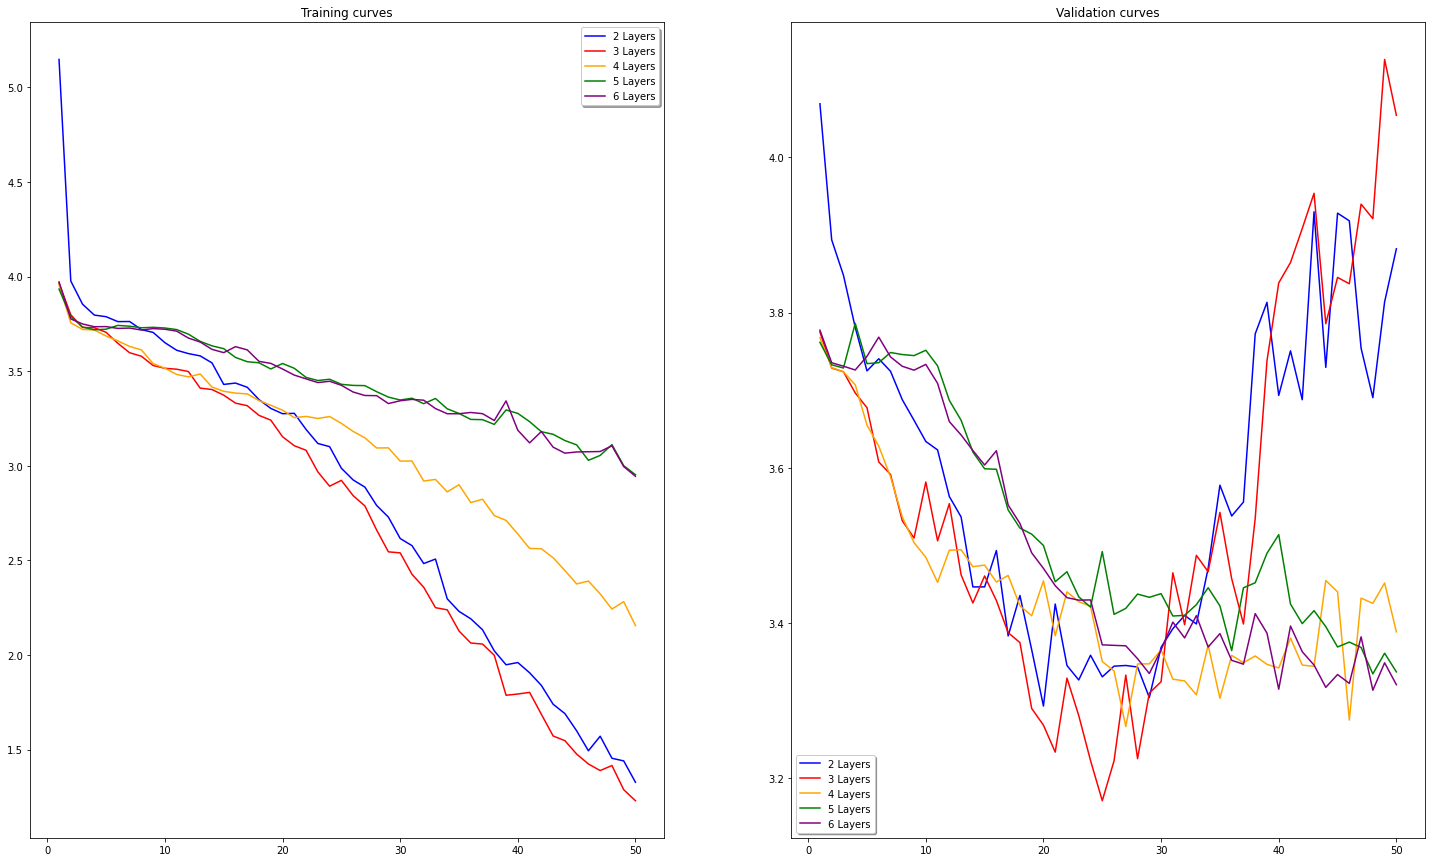

In [ ]:

epoch_list = []
epoch_list.append(epoch_list_2layers)
epoch_list.append(epoch_list_3layers)
epoch_list.append(epoch_list_4layers)
epoch_list.append(epoch_list_5layers)
epoch_list.append(epoch_list_6layers)

train_loss_list = []
train_loss_list.append(train_loss_list_2layers)
train_loss_list.append(train_loss_list_3layers)
train_loss_list.append(train_loss_list_4layers)
train_loss_list.append(train_loss_list_5layers)
train_loss_list.append(train_loss_list_6layers)

val_loss_list = []
val_loss_list.append(val_loss_list_2layers)
val_loss_list.append(val_loss_list_3layers)
val_loss_list.append(val_loss_list_4layers)
val_loss_list.append(val_loss_list_5layers)
val_loss_list.append(val_loss_list_6layers)

label = ['2 Layers', '3 Layers', '4 Layers', '5 Layers', '6 Layers']
color = ['blue','red','orange','green','purple']

my_plot(epoch_list,train_loss_list,val_loss_list,my_label,my_color)


In [ ]:
train_loss_list_noaug, val_loss_list_noaug, epoch_list_noaug = get_op([32,"M",32,"M",32,"M",32,"M",32,"M",32,"M"])

DataParallel(
  (module): Customnet(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): ReLU()
      (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU()
      (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, di

In [ ]:
train_loss_list_aug, val_loss_list_aug, epoch_list_aug = train_network([32,"M",32,"M",32,"M",32,"M",32,"M",32,"M"])

DataParallel(
  (module): Customnet(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): ReLU()
      (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU()
      (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, di

# Effect of Data Augmentation

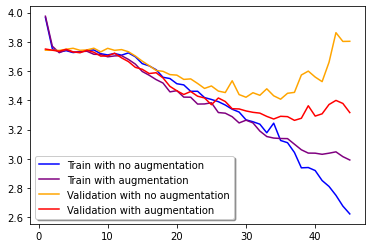

In [ ]:

epoch_list = []
epoch_list.append(epoch_list_noaug)
epoch_list.append(epoch_list_aug)
epoch_list.append(epoch_list_noaug)
epoch_list.append(epoch_list_aug)

train_loss_list = []
train_loss_list.append(train_loss_list_noaug)
train_loss_list.append(train_loss_list_aug)
train_loss_list.append(train_loss_list_noaug)
train_loss_list.append(train_loss_list_aug)


label = ['Train with no augmentation', 'Train with augmentation', 'Validation with no augmentation', 'Validation with augmentation']
color = ['blue','purple','orange','red']

my_plot1(epoch_list,train_loss_list,val_loss_list,my_label,my_color)


In [ ]:
train_loss_list_nobn, val_loss_list_nobn, epoch_list_nobn = get_op([32,"M",32,"M",32,"M",32,"M",32,"M",32,"M"])

DataParallel(
  (module): Customnet(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): ReLU()
      (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU()
      (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, di

In [ ]:
train_loss_list_bn, val_loss_list_bn, epoch_list_bn = get_op([32,"BN","M",32,"BN","M",32,"BN","M",32,"BN","M",32,"BN","M",32,"BN","M"])

DataParallel(
  (module): Customnet(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU()
      (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (

# Effect of Batch Normalisation

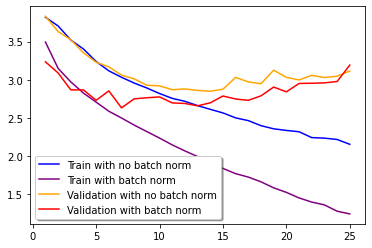

In [ ]:
epoch_list = []
epoch_list.append(epoch_list_nobn)
epoch_list.append(epoch_list_bn)
epoch_list.append(epoch_list_nobn)
epoch_list.append(epoch_list_bn)

train_loss_list = []
train_loss_list.append(train_loss_list_nobn)
train_loss_list.append(train_loss_list_bn)
train_loss_list.append(train_loss_list_nobn)
train_loss_list.append(train_loss_list_bn)


label = ['Train with no batch norm', 'Train with batch norm', 'Validation with no batch norm', 'Validation with batch norm']
color = ['blue','purple','orange','red']

my_plot1(epoch_list,train_loss_list,val_loss_list,my_label,my_color)


Batch normalization normalizes the output of a previous layer by subtracting the batch mean and dividing by the batch standard deviation.

- We can see that batch normalisation prodoces better results in both training and validation. But why?

1. This is because it combats the issue of the well known internal covariance shift. To put it briefly, when a function learns a mapping from x to y, it should be invariant to any shift in distribution of x. Otherwise, it will not be able to generalise.

Thus, I will be using batch normalisation.

In [ ]:
train_loss_list_M, val_loss_list_M, epoch_list_M = get_op([32,"M",32,"M",32,"M",32,"M",32,"M",32,"M"])

DataParallel(
  (module): Customnet(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): ReLU()
      (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU()
      (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, di

In [ ]:
train_loss_list_AP, val_loss_list_AP, epoch_list_AP = get_op([32,"AP",32,"AP",32,"AP",32,"AP",32,"AP",32,"AP"])

DataParallel(
  (module): Customnet(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
      (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
      (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): ReLU()
      (11): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
      (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU()
      (14): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
      (15): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (16): ReLU()
      (17): AvgPool2d

In [ ]:
train_loss_list_LLP, val_loss_list_LLP, epoch_list_LLP = get_op([32,"LPP",32,"LPP",32,"LPP",32,"LPP",32,"LPP",32,"LPP"])

DataParallel(
  (module): Customnet(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): LPPool2d(norm_type=2, kernel_size=(2, 2), stride=(2, 2), ceil_mode=False)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): LPPool2d(norm_type=2, kernel_size=(2, 2), stride=(2, 2), ceil_mode=False)
      (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): LPPool2d(norm_type=2, kernel_size=(2, 2), stride=(2, 2), ceil_mode=False)
      (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): ReLU()
      (11): LPPool2d(norm_type=2, kernel_size=(2, 2), stride=(2, 2), ceil_mode=False)
      (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU()
      (14): LPPool2d(norm_type=2, kernel_size=(2, 2), stride=(2, 2), ceil_mode=False)
      (15): Conv2d(32, 32, k

In [ ]:
train_loss_list_AMP, val_loss_list_AMP, epoch_list_AMP = get_op([32,"AMP",32,"AMP",32,"AMP",32,"AMP",32,"AMP",32,"AMP"])

DataParallel(
  (module): Customnet(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): AdaptiveMaxPool2d(output_size=(112, 112))
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): AdaptiveMaxPool2d(output_size=(56, 56))
      (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): AdaptiveMaxPool2d(output_size=(28, 28))
      (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): ReLU()
      (11): AdaptiveMaxPool2d(output_size=(14, 14))
      (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU()
      (14): AdaptiveMaxPool2d(output_size=(7, 7))
      (15): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (16): ReLU()
      (17): AdaptiveMaxPool2d(output_size=(3, 3))
    )
    (linear): Sequential(
      (0): Linear(i

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x14f2600b7048>>
Traceback (most recent call last):
  File "/home/avinash123/miniconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/avinash123/miniconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1291, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Epoch: 15 	 Training Loss: 3.573173 	 Validation Loss: 3.554354
--- 6.011480808258057 seconds ---
Epoch: 16 	 Training Loss: 3.565473 	 Validation Loss: 3.562473
--- 6.023367404937744 seconds ---
Epoch: 17 	 Training Loss: 3.530759 	 Validation Loss: 3.507503
--- 6.021219253540039 seconds ---
Epoch: 18 	 Training Loss: 3.515510 	 Validation Loss: 3.533506
--- 5.719873428344727 seconds ---
Epoch: 19 	 Training Loss: 3.473228 	 Validation Loss: 3.484536
--- 6.569025039672852 seconds ---
Epoch: 20 	 Training Loss: 3.473953 	 Validation Loss: 3.508602
--- 6.354980230331421 seconds ---
Epoch: 21 	 Training Loss: 3.502075 	 Validation Loss: 3.534688
--- 6.317458868026733 seconds ---
Epoch: 22 	 Training Loss: 3.439021 	 Validation Loss: 3.496747
--- 6.429659128189087 seconds ---
Epoch: 23 	 Training Loss: 3.447471 	 Validation Loss: 3.453981
--- 6.130399703979492 seconds ---
Epoch: 24 	 Training Loss: 3.435766 	 Validation Loss: 3.409299
--- 6.29675555229187 seconds ---
Epoch: 25 	 Training 

In [ ]:
train_loss_list_AAP, val_loss_list_AAP, epoch_list_AAP = get_op([32,"AAP",32,"AAP",32,"AAP",32,"AAP",32,"AAP",32,"AAP"])

DataParallel(
  (module): Customnet(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): AdaptiveAvgPool2d(output_size=(112, 112))
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): AdaptiveAvgPool2d(output_size=(56, 56))
      (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): AdaptiveAvgPool2d(output_size=(28, 28))
      (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): ReLU()
      (11): AdaptiveAvgPool2d(output_size=(14, 14))
      (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU()
      (14): AdaptiveAvgPool2d(output_size=(7, 7))
      (15): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (16): ReLU()
      (17): AdaptiveAvgPool2d(output_size=(3, 3))
    )
    (linear): Sequential(
      (0): Linear(i

# Comparing different pooling strategies

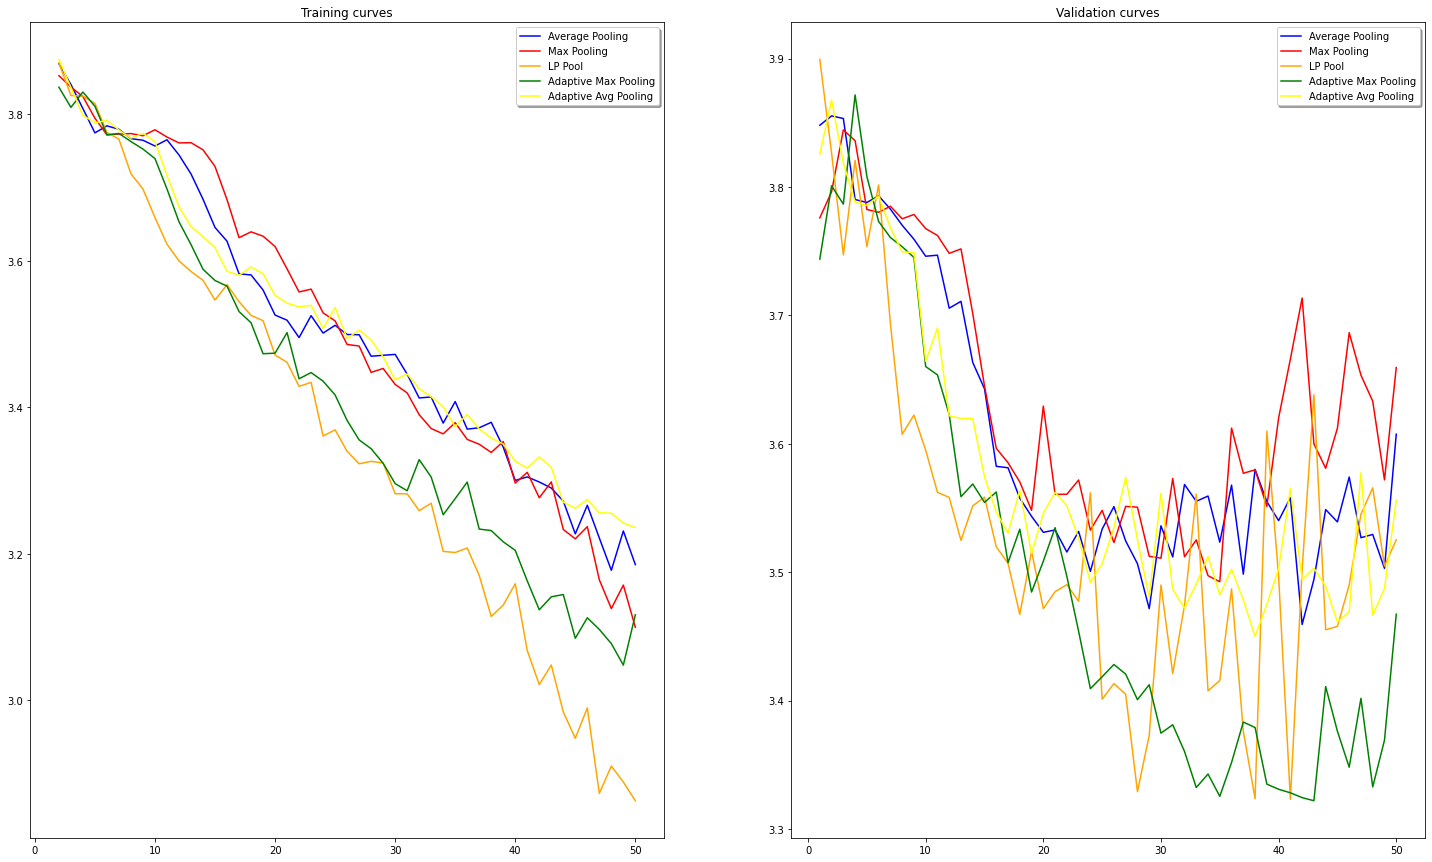

In [ ]:
epoch_list = []
epoch_list.append(epoch_list_AP[1:])
epoch_list.append(epoch_list_M[1:])
epoch_list.append(epoch_list_LLP[1:])
epoch_list.append(epoch_list_AMP[1:])
epoch_list.append(epoch_list_AAP[1:])

train_loss_list = []
train_loss_list.append(train_loss_list_AP[1:])
train_loss_list.append(train_loss_list_M[1:])
train_loss_list.append(train_loss_list_LLP[1:])
train_loss_list.append(train_loss_list_AMP[1:])
train_loss_list.append(train_loss_list_AAP[1:])

val_loss_list = []
val_loss_list.append(val_loss_list_AP)
val_loss_list.append(val_loss_list_M)
val_loss_list.append(val_loss_list_LLP)
val_loss_list.append(val_loss_list_AMP)
val_loss_list.append(val_loss_list_AAP)

label = ['Average Pooling', 'Max Pooling', 'LP Pool', 'Adaptive Max Pooling', 'Adaptive Avg Pooling']
color = ['blue','red','orange','green','purple']

my_plot(epoch_list,train_loss_list,val_loss_list,my_label,my_color)


In [ ]:
train_loss_list_Adam, val_loss_list_Adam, epoch_list_Adam = get_op([32,"M",32,"M",32,"M",32,"M",32,"M",32,"M"])

Epoch: 1 	 Training Loss: 3.986693 	 Validation Loss: 3.922584
--- 5.839144945144653 seconds ---
Epoch: 2 	 Training Loss: 3.830778 	 Validation Loss: 3.814159
--- 5.985350608825684 seconds ---
Epoch: 3 	 Training Loss: 3.797647 	 Validation Loss: 3.792651
--- 6.011790037155151 seconds ---
Epoch: 4 	 Training Loss: 3.792961 	 Validation Loss: 3.788616
--- 6.026220798492432 seconds ---
Epoch: 5 	 Training Loss: 3.770129 	 Validation Loss: 3.775195
--- 5.852612018585205 seconds ---
Epoch: 6 	 Training Loss: 3.763816 	 Validation Loss: 3.769921
--- 5.8328328132629395 seconds ---
Epoch: 7 	 Training Loss: 3.749211 	 Validation Loss: 3.775968
--- 6.160241603851318 seconds ---
Epoch: 8 	 Training Loss: 3.743659 	 Validation Loss: 3.787029
--- 5.888641834259033 seconds ---
Epoch: 9 	 Training Loss: 3.748965 	 Validation Loss: 3.783417
--- 5.963023662567139 seconds ---
Epoch: 10 	 Training Loss: 3.738302 	 Validation Loss: 3.808748
--- 6.083048582077026 seconds ---
Epoch: 11 	 Training Loss: 3

In [ ]:
train_loss_list_SGD, val_loss_list_SGD, epoch_list_SGD = get_op([32,"M",32,"M",32,"M",32,"M",32,"M",32,"M"])

Epoch: 1 	 Training Loss: 4.109740 	 Validation Loss: 4.112790
--- 5.806859016418457 seconds ---
Epoch: 2 	 Training Loss: 4.109934 	 Validation Loss: 4.112394
--- 6.029318809509277 seconds ---
Epoch: 3 	 Training Loss: 4.109714 	 Validation Loss: 4.112000
--- 5.728398323059082 seconds ---
Epoch: 4 	 Training Loss: 4.109902 	 Validation Loss: 4.111602
--- 6.059335470199585 seconds ---
Epoch: 5 	 Training Loss: 4.109324 	 Validation Loss: 4.111198
--- 5.862970590591431 seconds ---
Epoch: 6 	 Training Loss: 4.109296 	 Validation Loss: 4.110799
--- 6.051207542419434 seconds ---
Epoch: 7 	 Training Loss: 4.108553 	 Validation Loss: 4.110399
--- 5.77765154838562 seconds ---
Epoch: 8 	 Training Loss: 4.108786 	 Validation Loss: 4.110003
--- 5.807564973831177 seconds ---
Epoch: 9 	 Training Loss: 4.107713 	 Validation Loss: 4.109607
--- 6.002314567565918 seconds ---
Epoch: 10 	 Training Loss: 4.107589 	 Validation Loss: 4.109211
--- 5.694839239120483 seconds ---
Epoch: 11 	 Training Loss: 4.1

In [ ]:
train_loss_list_Adadelta, val_loss_list_Adadelta, epoch_list_Adadelta = get_op([32,"M",32,"M",32,"M",32,"M",32,"M",32,"M"])

Epoch: 1 	 Training Loss: 4.228833 	 Validation Loss: 3.999550
--- 5.771372318267822 seconds ---
Epoch: 2 	 Training Loss: 3.886266 	 Validation Loss: 3.809449
--- 5.923534154891968 seconds ---
Epoch: 3 	 Training Loss: 3.791943 	 Validation Loss: 3.781451
--- 5.809154272079468 seconds ---
Epoch: 4 	 Training Loss: 3.777627 	 Validation Loss: 3.769339
--- 6.086501598358154 seconds ---
Epoch: 5 	 Training Loss: 3.778718 	 Validation Loss: 3.765785
--- 6.003975868225098 seconds ---
Epoch: 6 	 Training Loss: 3.770938 	 Validation Loss: 3.764837
--- 5.854353189468384 seconds ---
Epoch: 7 	 Training Loss: 3.759662 	 Validation Loss: 3.771706
--- 5.965904235839844 seconds ---
Epoch: 8 	 Training Loss: 3.759942 	 Validation Loss: 3.765025
--- 5.80649209022522 seconds ---
Epoch: 9 	 Training Loss: 3.769168 	 Validation Loss: 3.772961
--- 6.01239013671875 seconds ---
Epoch: 10 	 Training Loss: 3.746985 	 Validation Loss: 3.762575
--- 5.768808841705322 seconds ---
Epoch: 11 	 Training Loss: 3.73

In [ ]:
train_loss_list_RMS, val_loss_list_RMS, epoch_list_RMS = get_op([32,"M",32,"M",32,"M",32,"M",32,"M",32,"M"])

Epoch: 1 	 Training Loss: 1638716.517501 	 Validation Loss: 4.026347
--- 5.786592245101929 seconds ---
Epoch: 2 	 Training Loss: 4.056217 	 Validation Loss: 3.904002
--- 6.035700082778931 seconds ---
Epoch: 3 	 Training Loss: 3.935421 	 Validation Loss: 3.841889
--- 5.900118112564087 seconds ---
Epoch: 4 	 Training Loss: 3.882931 	 Validation Loss: 3.837030
--- 6.134537696838379 seconds ---
Epoch: 5 	 Training Loss: 3.821833 	 Validation Loss: 3.834807
--- 5.735567569732666 seconds ---
Epoch: 6 	 Training Loss: 3.797509 	 Validation Loss: 3.801719
--- 5.831966161727905 seconds ---
Epoch: 7 	 Training Loss: 3.797914 	 Validation Loss: 3.810721
--- 5.7709667682647705 seconds ---
Epoch: 8 	 Training Loss: 3.784230 	 Validation Loss: 3.800254
--- 5.904253244400024 seconds ---
Epoch: 9 	 Training Loss: 3.790276 	 Validation Loss: 3.798298
--- 5.90570592880249 seconds ---
Epoch: 10 	 Training Loss: 3.766405 	 Validation Loss: 3.789762
--- 6.019677400588989 seconds ---
Epoch: 11 	 Training Lo

In [ ]:
train_loss_list_Adagrad, val_loss_list_Adagrad, epoch_list_Adagrad = get_op([32,"M",32,"M",32,"M",32,"M",32,"M",32,"M"])

Epoch: 1 	 Training Loss: 4.833453 	 Validation Loss: 3.830567
--- 5.8257856369018555 seconds ---
Epoch: 2 	 Training Loss: 3.796431 	 Validation Loss: 3.771429
--- 5.6443517208099365 seconds ---
Epoch: 3 	 Training Loss: 3.762273 	 Validation Loss: 3.765316
--- 5.840245008468628 seconds ---
Epoch: 4 	 Training Loss: 3.765189 	 Validation Loss: 3.764252
--- 5.906088352203369 seconds ---
Epoch: 5 	 Training Loss: 3.745110 	 Validation Loss: 3.769482
--- 5.911375284194946 seconds ---
Epoch: 6 	 Training Loss: 3.759521 	 Validation Loss: 3.774367
--- 5.58275032043457 seconds ---
Epoch: 7 	 Training Loss: 3.762483 	 Validation Loss: 3.782558
--- 6.045877933502197 seconds ---
Epoch: 8 	 Training Loss: 3.751674 	 Validation Loss: 3.778748
--- 6.276329517364502 seconds ---
Epoch: 9 	 Training Loss: 3.748977 	 Validation Loss: 3.800841
--- 6.026983022689819 seconds ---
Epoch: 10 	 Training Loss: 3.747346 	 Validation Loss: 3.779453
--- 6.092941999435425 seconds ---
Epoch: 11 	 Training Loss: 3

# Effect of different optimizers

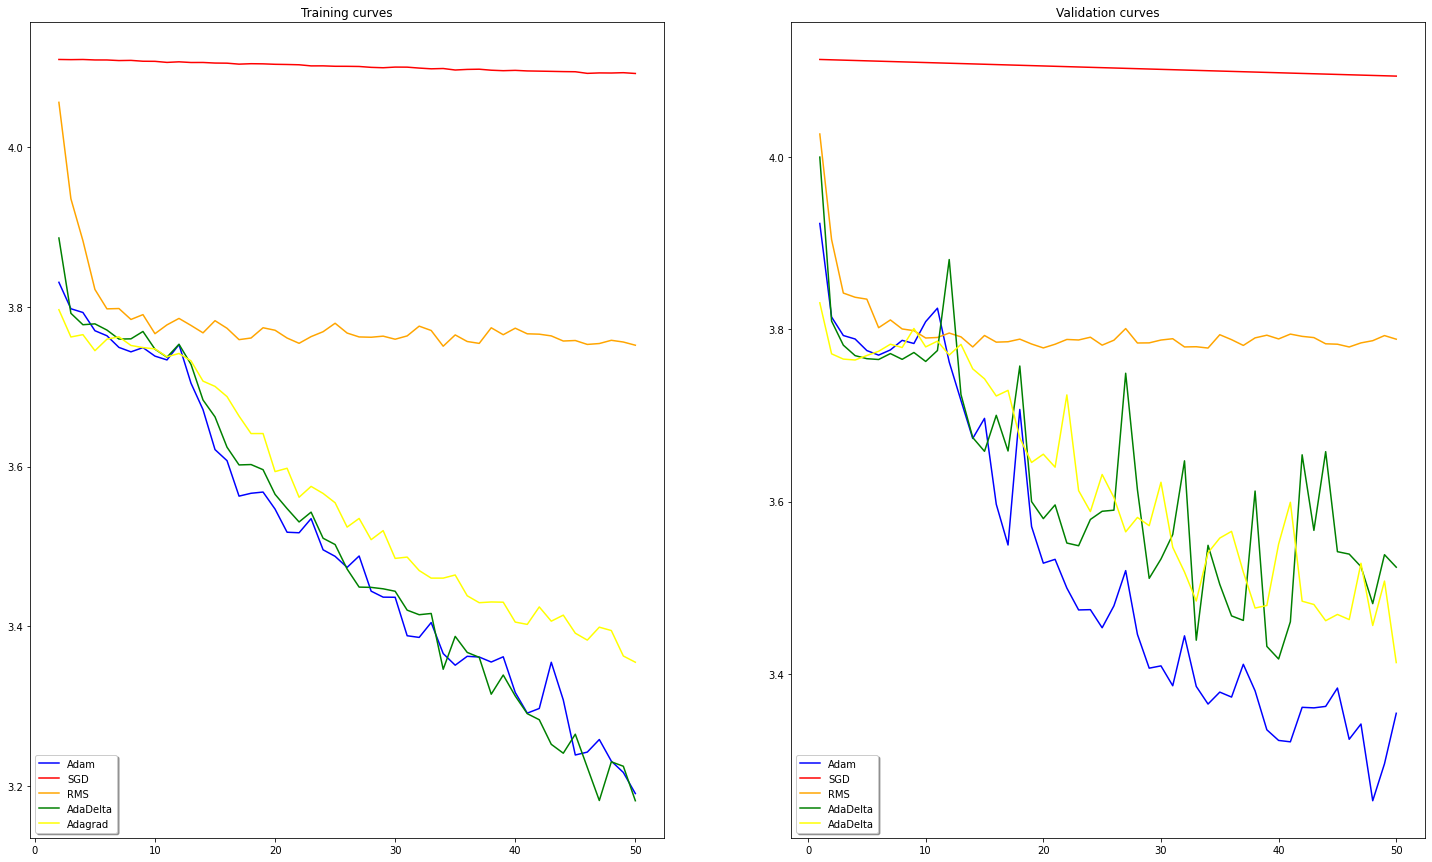

In [ ]:

epoch_list = []
epoch_list.append(epoch_list_Adam[1:])
epoch_list.append(epoch_list_SGD[1:])
epoch_list.append(epoch_list_RMS[1:])
epoch_list.append(epoch_list_Adadelta[1:])
epoch_list.append(epoch_list_Adagrad[1:])

train_loss_list = []
train_loss_list.append(train_loss_list_Adam[1:])
train_loss_list.append(train_loss_list_SGD[1:])
train_loss_list.append(train_loss_list_RMS[1:])
train_loss_list.append(train_loss_list_Adadelta[1:])
train_loss_list.append(train_loss_list_Adagrad[1:])

val_loss_list = []
val_loss_list.append(val_loss_list_Adam)
val_loss_list.append(val_loss_list_SGD)
val_loss_list.append(val_loss_list_RMS)
val_loss_list.append(val_loss_list_Adadelta)
val_loss_list.append(val_loss_list_Adagrad)

label = ['Adam', 'SGD', 'RMS', 'AdaDelta', 'Adagrad']
color = ['blue','red','orange','green','yellow']

my_plot(epoch_list,train_loss_list,val_loss_list,my_label,my_color)



In [ ]:
train_loss_list_relu, val_loss_list_relu, epoch_list_relu = get_op([32,"relu","M",32,"relu","M",32,"relu","M",32,"relu","M",32,"relu","M",32,"relu","M"])

DataParallel(
  (module): Customnet(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): ReLU()
      (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU()
      (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, di

In [ ]:
train_loss_list_tanh, val_loss_list_tanh, epoch_list_tanh = get_op([32,"tanh","M",32,"tanh","M",32,"tanh","M",32,"tanh","M",32,"tanh","M",32,"tanh","M"])

DataParallel(
  (module): Customnet(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Tanh()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): Tanh()
      (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): Tanh()
      (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): Tanh()
      (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): Tanh()
      (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, di

In [ ]:
train_loss_list_sigmoid, val_loss_list_sigmoid, epoch_list_sigmoid = get_op([32,"sigmoid","M",32,"sigmoid","M",32,"sigmoid","M",32,"sigmoid","M",32,"sigmoid","M",32,"sigmoid","M"])

DataParallel(
  (module): Customnet(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Sigmoid()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): Sigmoid()
      (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): Sigmoid()
      (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): Sigmoid()
      (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): Sigmoid()
      (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2)

# Effect of Different Activation Functions

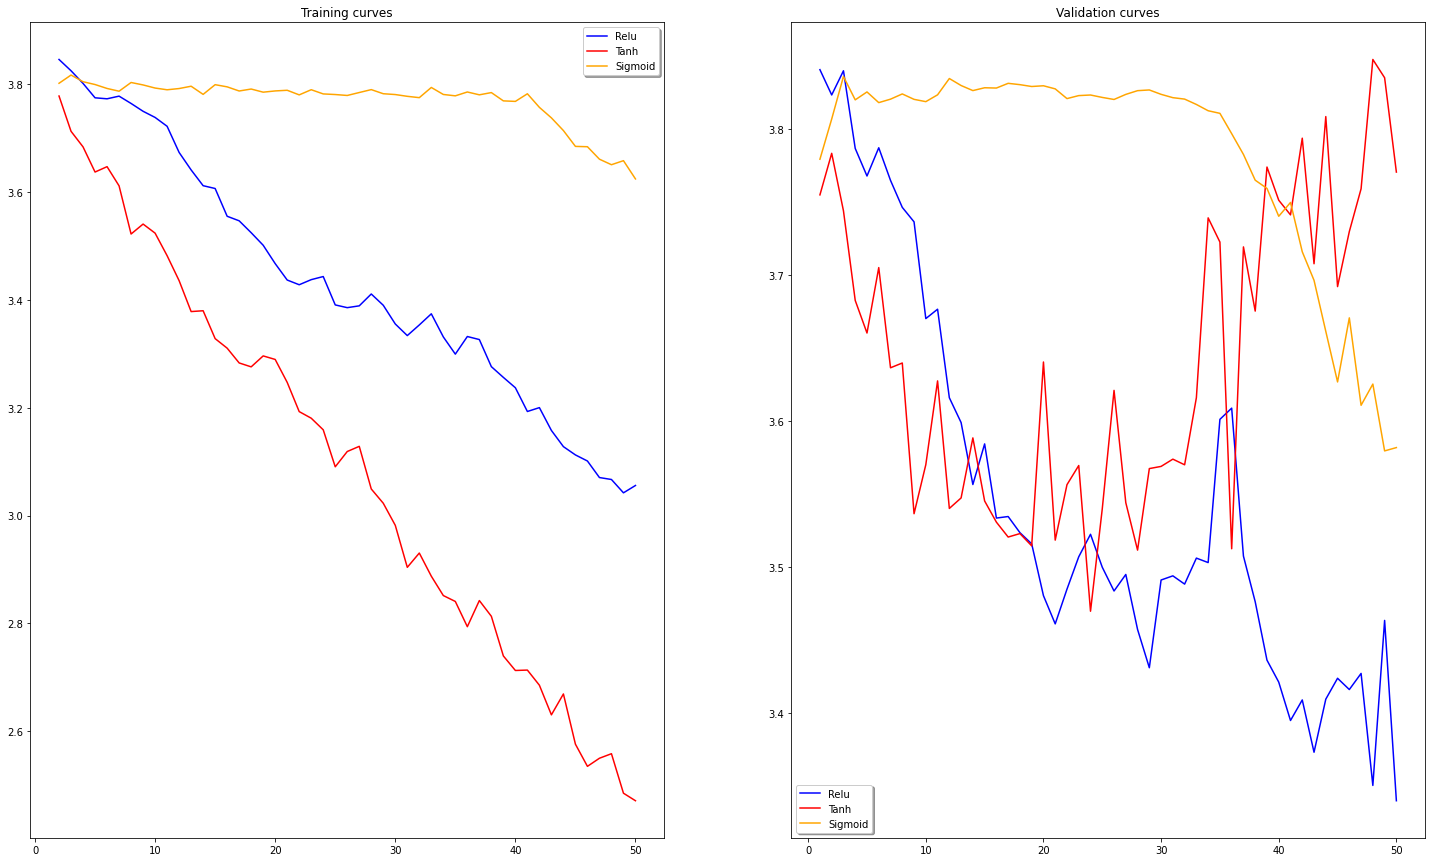

In [ ]:

epoch_list = []
epoch_list.append(epoch_list_relu[1:])
epoch_list.append(epoch_list_tanh[1:])
epoch_list.append(epoch_list_sigmoid[1:])

train_loss_list = []
train_loss_list.append(train_loss_list_relu[1:])
train_loss_list.append(train_loss_list_tanh[1:])
train_loss_list.append(train_loss_list_sigmoid[1:])

val_loss_list = []
val_loss_list.append(val_loss_list_relu)
val_loss_list.append(val_loss_list_tanh)
val_loss_list.append(val_loss_list_sigmoid)

label = ['Relu', 'Tanh', 'Sigmoid']
color = ['blue','red','orange']

my_plot(epoch_list,train_loss_list,val_loss_list,my_label,my_color)



In [ ]:
train_loss_list_nodp, val_loss_list_nodp, epoch_list_nodp = get_op([32,"relu","M",32,"relu","M",32,"relu","M",32,"relu","M",32,"relu","M",32,"relu","M"])

DataParallel(
  (module): Customnet(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): ReLU()
      (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU()
      (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, di

Epoch: 69 	 Training Loss: 2.763701 	 Validation Loss: 3.614226
--- 6.480140924453735 seconds ---
Epoch: 70 	 Training Loss: 2.685139 	 Validation Loss: 3.559033
--- 6.568313837051392 seconds ---
Epoch: 71 	 Training Loss: 2.753248 	 Validation Loss: 3.567385
--- 7.288163661956787 seconds ---
Epoch: 72 	 Training Loss: 2.683910 	 Validation Loss: 3.707702
--- 7.070204496383667 seconds ---
Epoch: 73 	 Training Loss: 2.728682 	 Validation Loss: 3.664911
--- 7.602255821228027 seconds ---
Epoch: 74 	 Training Loss: 2.752370 	 Validation Loss: 3.533825
--- 7.221494436264038 seconds ---
Epoch: 75 	 Training Loss: 2.644221 	 Validation Loss: 3.565028
--- 6.867828845977783 seconds ---
Epoch: 76 	 Training Loss: 2.613121 	 Validation Loss: 3.603324
--- 6.763660192489624 seconds ---
Epoch: 77 	 Training Loss: 2.625251 	 Validation Loss: 3.628265
--- 7.1159138679504395 seconds ---
Epoch: 78 	 Training Loss: 2.684638 	 Validation Loss: 3.541655
--- 7.334151744842529 seconds ---
Epoch: 79 	 Trainin

In [ ]:
train_loss_list_dp, val_loss_list_dp, epoch_list_dp = get_op([32,"dropout","relu","M",32,"dropout","relu","M",32,"dropout","relu","M",32,"dropout","relu","M",32,"dropout","relu","M",32,"dropout","relu","M"])

DataParallel(
  (module): Customnet(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Dropout2d(p=0.5, inplace=False)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Dropout2d(p=0.5, inplace=False)
      (6): ReLU()
      (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): Dropout2d(p=0.5, inplace=False)
      (10): ReLU()
      (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): Dropout2d(p=0.5, inplace=False)
      (14): ReLU()
      (15): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mod

Epoch: 66 	 Training Loss: 3.711376 	 Validation Loss: 3.729858
--- 7.2399516105651855 seconds ---
Epoch: 67 	 Training Loss: 3.741200 	 Validation Loss: 3.733349
--- 6.92961859703064 seconds ---
Epoch: 68 	 Training Loss: 3.725655 	 Validation Loss: 3.720595
--- 6.930811643600464 seconds ---
Epoch: 69 	 Training Loss: 3.680254 	 Validation Loss: 3.701079
--- 7.08367657661438 seconds ---
Epoch: 70 	 Training Loss: 3.682044 	 Validation Loss: 3.707776
--- 7.667216777801514 seconds ---
Epoch: 71 	 Training Loss: 3.689380 	 Validation Loss: 3.703724
--- 7.126468658447266 seconds ---
Epoch: 72 	 Training Loss: 3.716294 	 Validation Loss: 3.734819
--- 6.554215669631958 seconds ---
Epoch: 73 	 Training Loss: 3.668683 	 Validation Loss: 3.677209
--- 6.5454912185668945 seconds ---
Epoch: 74 	 Training Loss: 3.693137 	 Validation Loss: 3.639959
--- 6.605918645858765 seconds ---
Epoch: 75 	 Training Loss: 3.663746 	 Validation Loss: 3.640403
--- 7.132815599441528 seconds ---
Epoch: 76 	 Training

# Effect of dropout

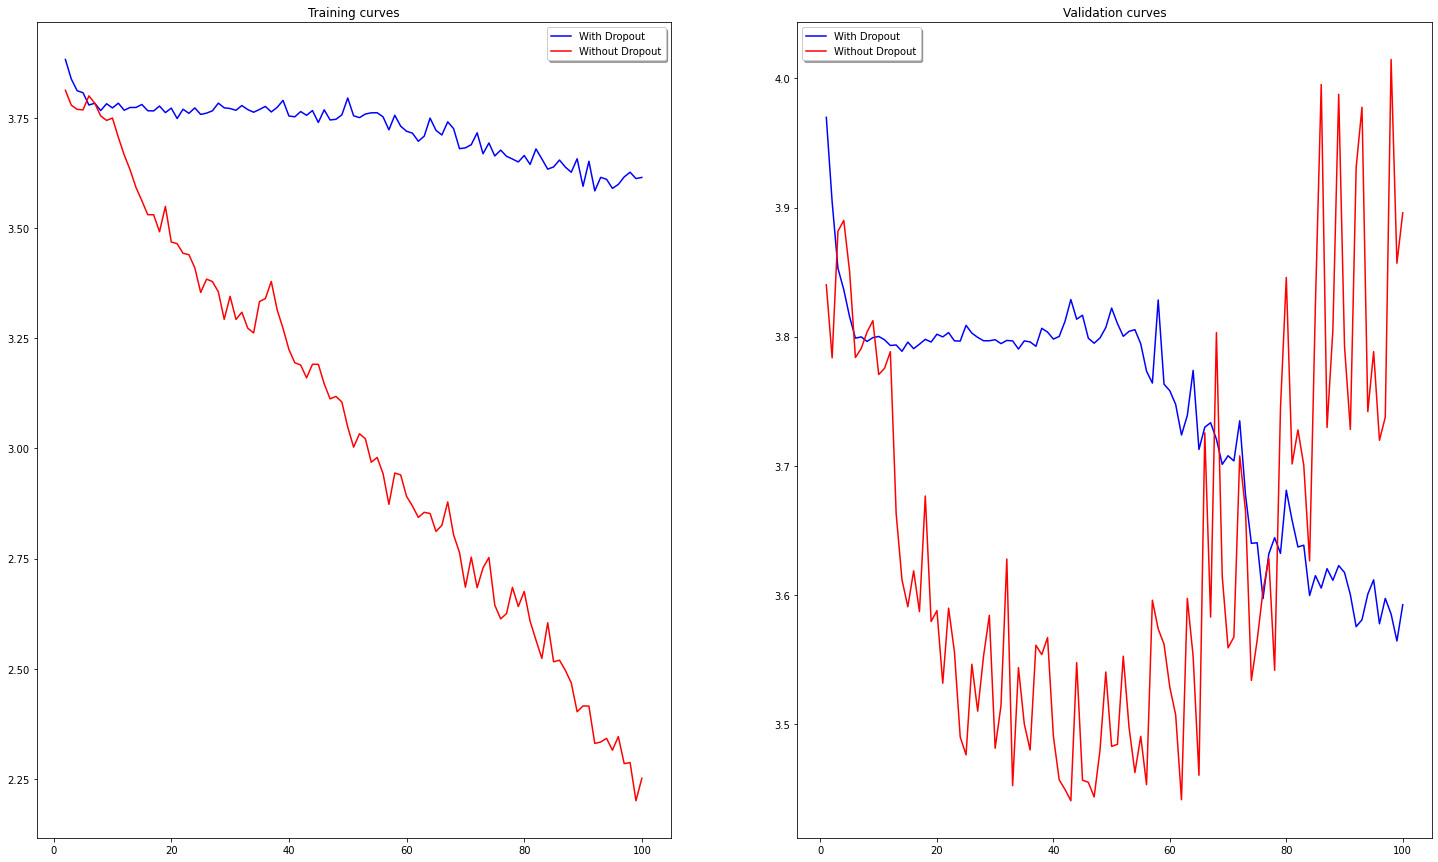

In [ ]:
epoch_list = []
epoch_list.append(epoch_list_dp[1:])
epoch_list.append(epoch_list_nodp[1:])

train_loss_list = []
train_loss_list.append(train_loss_list_dp[1:])
train_loss_list.append(train_loss_list_nodp[1:])
val_loss_list = []
val_loss_list.append(val_loss_list_dp)
val_loss_list.append(val_loss_list_nodp)

label = ['With Dropout', 'Without Dropout']
color = ['blue','red']

my_plot(epoch_list,train_loss_list,val_loss_list,my_label,my_color)

